# Resource Analysis of Toggling, Adjoint, and Universal Robustness Objectives for Constraints and Penalty Methods


## Imports

In [1]:
import Pkg; Pkg.activate(@__DIR__); Pkg.instantiate();
Pkg.develop(path="../../QuantumCollocation.jl")
using PiccoloQuantumObjects
using QuantumCollocation
using ForwardDiff
using LinearAlgebra
using Plots
using SparseArrays
using NamedTrajectories
using Statistics
using CairoMakie
using Random
using ColorSchemes
using Makie
using Printf

  Activating project at `~/Documents/research/pulses/project/notebooks/src`
┌ Warning: Circular dependency detected.
│ Precompilation will be skipped for dependencies in this cycle:
│  ┌ Piccolissimo
│  └─ QuantumCollocation
└ @ Base.Precompilation precompilation.jl:651
   Resolving package versions...
  No Changes to `~/Documents/research/pulses/project/notebooks/src/Project.toml`
  No Changes to `~/Documents/research/pulses/project/notebooks/src/Manifest.toml`
┌ Warning: Circular dependency detected.
│ Precompilation will be skipped for dependencies in this cycle:
│  ┌ Piccolissimo
│  └─ QuantumCollocation
└ @ Base.Precompilation precompilation.jl:651
┌ Warning: Replacing docs for `QuantumCollocation.ProblemTemplates.UnitaryToggleProblem :: Union{}` in module `QuantumCollocation.ProblemTemplates`
└ @ Base.Docs docs/Docs.jl:243
ERROR: Method overwriting is not permitted during Module precompilation. Use `__precompile__(false)` to opt-out of precompilation.
┌ Warning: Replacing docs fo

In [2]:
# Problem parameters
T = 40
Δt = 0.2
U_goal = GATES.H
H_drive = [PAULIS.X, PAULIS.Y, PAULIS.Z]
piccolo_opts = PiccoloOptions(verbose=false)
pretty_print(X::AbstractMatrix) = Base.show(stdout, "text/plain", X);

sys = QuantumSystem(H_drive)

∂ₑHₐ = [PAULIS.X, PAULIS.Y, PAULIS.Z]
var_sys = VariationalQuantumSystem(
    H_drive,
    ∂ₑHₐ
)


VariationalQuantumSystem: levels = 2, n_drives = 3

In [3]:
n_guesses = 5
n_drives = sys.n_drives
var_n_drives = var_sys.n_drives
variational_scales = fill(1.0, length(var_sys.G_vars))
seeds = []
n_seeds = n_guesses



for i in 1:n_seeds
    Random.seed!(1234+10*i)
    a_bounds = fill(1.0, n_drives)
    da_bounds = fill(1.0, n_drives)
    # da_bounds = fill((5.5+0.5*i)*π*Δt/T, n_drives)
    dda_bounds = fill(10^(1.5-0.5*i), n_drives)
    control_bounds = (a_bounds, da_bounds, dda_bounds)
    traj = initialize_trajectory(
                    U_goal,
                    T,
                    Δt,
                    n_drives,
                    control_bounds;
                    system=sys
                )
    push!(seeds, traj)
end

a_vals = exp.(range(log(100), log(100000), length=8))
final_fid_floor_log = 1 .- 1 ./ a_vals
final_fid_floor = final_fid_floor_log

n_nines = length(final_fid_floor)
default_probs = Matrix{Any}(undef, n_seeds, n_nines)
init_var_probs = Matrix{Any}(undef, n_seeds, n_nines)
init_tog_probs = Matrix{Any}(undef, n_seeds, n_nines)
init_uni_probs = Matrix{Any}(undef, n_seeds, n_nines)

init_def_fids = zeros(n_seeds, n_nines)
init_var_fids = zeros(n_seeds, n_nines)
init_tog_fids = zeros(n_seeds, n_nines)
init_uni_fids = zeros(n_seeds, n_nines)

Hₑ_add = a -> [PAULIS.X, PAULIS.Y, PAULIS.Z]
X_drive = sys.H.H_drives[1]
Hₑ_mult = a -> a[1] * X_drive
H₀_add = Hₑ_add

for i in 1:n_seeds
    for j in 1:n_nines
        Random.seed!(1234+10*i)
        # default case (no robustness)
        default = UnitarySmoothPulseProblem(sys, U_goal, T, Δt; init_trajectory=deepcopy(seeds[i]))
        default_probs[i, j] = default
        def_fid = unitary_rollout_fidelity(default_probs[i, j].trajectory, sys)
        init_def_fids[i,j] = def_fid

        # variational objective
        var_prob = UnitaryVariationalProblem(var_sys, U_goal, T, Δt; init_trajectory=deepcopy(seeds[i]), robust_times=[[T], [T], [T]], Q_r=0.1, piccolo_options=piccolo_opts)
        init_var_probs[i, j] = var_prob
        var_fid = unitary_rollout_fidelity(init_var_probs[i, j].trajectory, sys)
        init_var_fids[i,j] = var_fid

        # toggling objective
        tog_prob = UnitarySmoothPulseProblem(sys, U_goal, T, Δt; init_trajectory=deepcopy(seeds[i]), activate_rob_loss=true, H_err=Hₑ_add, Q_t=0.1)
        init_tog_probs[i, j] = tog_prob
        tog_fid = unitary_rollout_fidelity(init_tog_probs[i, j].trajectory, sys)
        init_tog_fids[i,j] = tog_fid

        # universal objective
        uni_prob = UnitaryUniversalProblem(sys, U_goal, T, Δt; init_trajectory=deepcopy(seeds[i]), activate_hyperspeed=true)
        init_uni_probs[i, j] = uni_prob
        uni_fid = unitary_rollout_fidelity(init_uni_probs[i, j].trajectory, sys)
        init_uni_fids[i,j] = uni_fid

    end
end

for i in 1:n_seeds
    for j in 1:n_nines
        
        takes = 1
        while takes < 200 && init_var_fids[i,j] < final_fid_floor[j]
            solve!(init_var_probs[i, j]; max_iter=4, print_level=1, options=IpoptOptions(eval_hessian=false))
            init_var_fid = unitary_rollout_fidelity(init_var_probs[i, j].trajectory, sys)
            init_var_fids[i,j] = init_var_fid
            takes += 1
        end
        
        takes = 1
        while takes < 200 && init_tog_fids[i,j] < final_fid_floor[j]
            solve!(init_tog_probs[i, j]; max_iter=4, print_level=1, options=IpoptOptions(eval_hessian=false))
            init_tog_fid = unitary_rollout_fidelity(init_tog_probs[i, j].trajectory, sys)
            init_tog_fids[i,j] = init_tog_fid
            takes += 1
        end

        takes = 1
        while takes < 200 && init_uni_fids[i,j] < final_fid_floor[j]
            solve!(init_uni_probs[i, j]; max_iter=4, print_level=1, options=IpoptOptions(eval_hessian=false))
            init_uni_fid = unitary_rollout_fidelity(init_uni_probs[i, j].trajectory, sys)
            init_uni_fids[i,j] = init_uni_fid
            takes += 1
        end

        takes = 1
        while takes < 150 && init_def_fids[i,j] < final_fid_floor[j]
            solve!(default_probs[i, j]; max_iter=4, print_level=1)
            def_fid = unitary_rollout_fidelity(default_probs[i, j].trajectory, sys)
            init_def_fids[i, j] = def_fid
            takes += 1
        end

    end
end

for seed_idx in 1:n_seeds
    display("\nseed idx = $seed_idx:")
    display("Initial f | Base Fidelity | Variational Fidelity | Toggle Fidelity | Universal Fidelity | ")
    display("-" ^ 40)
    for (j, f) in enumerate(final_fid_floor)
            def_fid = unitary_rollout_fidelity(default_probs[seed_idx, j].trajectory, sys)
            var_fid = unitary_rollout_fidelity(init_var_probs[seed_idx, j].trajectory, var_sys)
            tog_fid = unitary_rollout_fidelity(init_tog_probs[seed_idx, j].trajectory, sys)
            uni_fid = unitary_rollout_fidelity(init_uni_probs[seed_idx, j].trajectory, sys)
            display("$(lpad(round(f, digits=6), 7)) | $(lpad(round(def_fid, digits=6), 12)) | $(lpad(round(var_fid, digits=6), 12)) | $(lpad(round(tog_fid, digits=6), 13)) | $(lpad(round(uni_fid, digits=6), 13)) |")
    end
end


    constructing UnitarySmoothPulseProblem...
	using integrator: DataType
	applying timesteps_all_equal constraint: Δt
    constructing UnitarySmoothPulseProblem...
	using integrator: DataType
	applying timesteps_all_equal constraint: Δt
    constructing UnitaryUniversalProblem...
	using integrator: DataType
	applying timesteps_all_equal constraint: Δt
    constructing UnitarySmoothPulseProblem...
	using integrator: DataType
	applying timesteps_all_equal constraint: Δt
    constructing UnitarySmoothPulseProblem...
	using integrator: DataType
	applying timesteps_all_equal constraint: Δt
    constructing UnitaryUniversalProblem...
	using integrator: DataType
	applying timesteps_all_equal constraint: Δt
    constructing UnitarySmoothPulseProblem...
	using integrator: DataType
	applying timesteps_all_equal constraint: Δt
    constructing UnitarySmoothPulseProblem...
	using integrator: DataType
	applying timesteps_all_equal constraint: Δt
    constructing UnitaryUniversalProblem...
	using i

Excessive output truncated after 524294 bytes.

    initializing optimizer...
        applying constraint: timesteps all equal constraint
        applying constraint: initial value of Ũ⃗
        applying constraint: initial value of a
        applying constraint: initial value of Ũ⃗ᵥ1
        applying constraint: initial value of Ũ⃗ᵥ2
        applying constraint: initial value of Ũ⃗ᵥ3
        applying constraint: final value of a
        applying constraint: bounds on a
        applying constraint: bounds on da

"\nseed idx = 1:"

"Initial f | Base Fidelity | Variational Fidelity | Toggle Fidelity | Universal Fidelity | "

"----------------------------------------"

"   0.99 |     0.990661 |     0.990665 |      0.992483 |      0.997821 |"

"0.996272 |     0.999672 |     0.998527 |      0.999597 |      0.997821 |"

"0.998611 |     0.999672 |     0.999999 |      0.999597 |      0.999936 |"

"0.999482 |     0.999672 |     0.999999 |      0.999597 |      0.999936 |"

"0.999807 |      0.99992 |     0.999999 |      0.999859 |      0.999936 |"

"0.999928 |     0.999989 |     0.999999 |      0.999991 |      0.999936 |"

"0.999973 |     0.999989 |     0.999999 |      0.999991 |       0.99999 |"

"0.99999 |     0.999999 |     0.999999 |      0.999991 |       0.99999 |"

"\nseed idx = 2:"

"Initial f | Base Fidelity | Variational Fidelity | Toggle Fidelity | Universal Fidelity | "

"----------------------------------------"

"   0.99 |     0.995489 |     0.991122 |      0.999765 |      0.999324 |"

"0.996272 |     0.998539 |     0.999362 |      0.999765 |      0.999324 |"

"0.998611 |     0.999592 |     0.999362 |      0.999765 |      0.999324 |"

"0.999482 |     0.999592 |     0.999676 |      0.999765 |      0.999985 |"

"0.999807 |      0.99996 |     0.999902 |           1.0 |      0.999985 |"

"0.999928 |      0.99996 |     0.999942 |           1.0 |      0.999985 |"

"0.999973 |     0.999996 |     0.949465 |           1.0 |      0.999985 |"

"0.99999 |     0.999996 |     0.949465 |           1.0 |           1.0 |"

"\nseed idx = 3:"

"Initial f | Base Fidelity | Variational Fidelity | Toggle Fidelity | Universal Fidelity | "

"----------------------------------------"

"   0.99 |     0.999969 |     0.994957 |      0.992769 |      0.999341 |"

"0.996272 |     0.999969 |     0.997836 |      0.998823 |      0.999341 |"

"0.998611 |     0.999969 |     0.998677 |      0.998823 |      0.999341 |"

"0.999482 |     0.999969 |      0.99963 |      0.999989 |      0.999759 |"

"0.999807 |     0.999969 |     0.999838 |      0.999989 |      0.999993 |"

"0.999928 |     0.999969 |     0.999948 |      0.999989 |      0.999993 |"

"0.999973 |          1.0 |     0.998249 |      0.999989 |      0.999993 |"

"0.99999 |          1.0 |     0.998249 |      0.999999 |      0.999993 |"

"\nseed idx = 4:"

"Initial f | Base Fidelity | Variational Fidelity | Toggle Fidelity | Universal Fidelity | "

"----------------------------------------"

"   0.99 |     0.992293 |     0.993937 |      0.999723 |      0.997969 |"

"0.996272 |     0.999854 |     0.994061 |      0.999723 |      0.997969 |"

"0.998611 |     0.999854 |     0.994061 |      0.999723 |      0.999975 |"

"0.999482 |     0.999854 |     0.994061 |      0.999723 |      0.999975 |"

"0.999807 |     0.999854 |     0.994061 |           1.0 |      0.999975 |"

"0.999928 |          1.0 |     0.994061 |           1.0 |      0.999975 |"

"0.999973 |          1.0 |     0.994061 |           1.0 |      0.999975 |"

"0.99999 |          1.0 |     0.994061 |           1.0 |      0.999996 |"

"\nseed idx = 5:"

"Initial f | Base Fidelity | Variational Fidelity | Toggle Fidelity | Universal Fidelity | "

"----------------------------------------"

"   0.99 |     0.999803 |     0.992838 |      0.997225 |       0.99011 |"

"0.996272 |     0.999803 |     0.993994 |      0.997225 |      0.999149 |"

"0.998611 |     0.999803 |     0.993994 |      0.999679 |      0.999149 |"

"0.999482 |     0.999803 |     0.993994 |      0.999679 |      0.999995 |"

"0.999807 |     0.999991 |     0.993994 |      0.999983 |      0.999995 |"

"0.999928 |     0.999991 |     0.993994 |      0.999983 |      0.999995 |"

"0.999973 |     0.999991 |     0.993994 |      0.999983 |      0.999995 |"

"0.99999 |     0.999991 |     0.993994 |      0.999999 |      0.999995 |"

helper functions for resource tracking

In [4]:
# Performance tracking structures
mutable struct SolverMetrics
    wall_times::Vector{Float64}
    iter_times::Vector{Float64}
    objectives::Vector{Float64}
    constraints::Vector{Float64}
    memory_usage::Vector{Float64}
    iterations::Vector{Int}
    convergence_rates::Vector{Float64}
    SolverMetrics() = new([], [], [], [], [], [], [])
end

function track_solver_performance(prob; max_iter=150, print_level=5)
    metrics = SolverMetrics()
    start_time = time()
    start_memory = Base.gc_live_bytes() / 1024^2
    
    result = solve!(prob; max_iter=max_iter, print_level=print_level)
    
    end_time = time()
    total_time = end_time - start_time
    end_memory = Base.gc_live_bytes() / 1024^2
    
    push!(metrics.wall_times, total_time)
    push!(metrics.memory_usage, end_memory - start_memory)
    
    # Get final objective
    try
        Z_vec = vec(prob.trajectory)
        push!(metrics.objectives, prob.objective.L(Z_vec))
    catch
        push!(metrics.objectives, NaN)
    end
    
    return metrics, total_time, end_memory - start_memory
end

function analyze_convergence(metrics::SolverMetrics)
    return Dict(
        "total_wall_time" => isempty(metrics.wall_times) ? 0.0 : metrics.wall_times[end],
        "peak_memory_mb" => isempty(metrics.memory_usage) ? 0.0 : maximum(metrics.memory_usage),
        "final_objective" => isempty(metrics.objectives) ? NaN : metrics.objectives[end]
    )
end

analyze_convergence (generic function with 1 method)

analyze resources for constrained optimzation across all objective

In [5]:
# Performance tracking for constraint-based methods
constraint_metrics = Dict(
    "variational" => Matrix{SolverMetrics}(undef, n_seeds, n_nines),
    "toggling" => Matrix{SolverMetrics}(undef, n_seeds, n_nines),
    "universal" => Matrix{SolverMetrics}(undef, n_seeds, n_nines)
)
final_var_probs = Matrix{Any}(undef, n_seeds, n_nines)
final_tog_probs = Matrix{Any}(undef, n_seeds, n_nines)
final_uni_probs = Matrix{Any}(undef, n_seeds, n_nines)

println("Solving constraint-based methods with performance tracking...")

for i in 1:n_seeds
    for j in 1:n_nines
        # Variational
        var_prob = UnitaryVariationalProblem(
            var_sys, U_goal, T, Δt;
            robust_times=[[T], [T], [T]],
            Q=0.0, Q_r=1.0,
            init_trajectory=init_var_probs[i,j].trajectory,
            var_seed=false,
            piccolo_options=piccolo_opts
        )
        F = final_fid_floor[j]
        push!(var_prob.constraints, FinalUnitaryFidelityConstraint(U_goal, :Ũ⃗, F, var_prob.trajectory))
        metrics, time, mem = track_solver_performance(var_prob; max_iter=40, print_level=1)
        constraint_metrics["variational"][i,j] = metrics
        final_var_probs[i,j] = var_prob
        
        # Toggling
        tog_prob = UnitaryMaxToggleProblem(
            init_tog_probs[i,j], U_goal, H₀_add;
            Q_t=1.0, final_fidelity=final_fid_floor[j],
            piccolo_options=piccolo_opts
        )
        metrics, time, mem = track_solver_performance(tog_prob; max_iter=40, print_level=1)
        constraint_metrics["toggling"][i,j] = metrics
        final_tog_probs[i,j] = tog_prob
        
        # Universal
        uni_prob = UnitaryMaxUniversalProblem(
            init_uni_probs[i,j], U_goal;
            Q_t=1.0, final_fidelity=final_fid_floor[j],
            piccolo_options=piccolo_opts
        )
        metrics, time, mem = track_solver_performance(uni_prob; max_iter=40, print_level=1)
        constraint_metrics["universal"][i,j] = metrics
        final_uni_probs[i,j] = uni_prob
    end
end

same as above but for penalty not constrained

In [17]:
# Performance tracking for penalty methods
sweep_rob_loss_λ = exp.(range(log(.1), log(1), length=8))
n_lambdas = length(sweep_rob_loss_λ)

penalty_metrics = Dict(
    "variational" => Matrix{SolverMetrics}(undef, n_seeds, n_lambdas),
    "toggling" => Matrix{SolverMetrics}(undef, n_seeds, n_lambdas),
    "universal" => Matrix{SolverMetrics}(undef, n_seeds, n_lambdas)
)
pen_var_probs = Matrix{Any}(undef, n_seeds, n_lambdas)
pen_tog_probs = Matrix{Any}(undef, n_seeds, n_lambdas)
pen_uni_probs = Matrix{Any}(undef, n_seeds, n_lambdas)


println("Solving penalty-based methods with performance tracking...")

for i in 1:n_seeds
    for (λ_idx, λ) in enumerate(sweep_rob_loss_λ)
        # Variational
        var_prob = UnitaryVariationalProblem(
            var_sys, U_goal, T, Δt;
            init_trajectory=deepcopy(init_var_probs[i,λ_idx].trajectory),
            piccolo_options=piccolo_opts,
            var_seed=false, Q_r=λ
        )
        metrics, time, mem = track_solver_performance(var_prob; max_iter=40, print_level=1)
        penalty_metrics["variational"][i, λ_idx] = metrics
        pen_var_probs[i, λ_idx] = var_prob
        
        # Toggling
        tog_prob = UnitarySmoothPulseProblem(
            sys, U_goal, T, Δt;
            init_trajectory=deepcopy(seeds[i]),
            piccolo_options=piccolo_opts,
            activate_rob_loss=true, H_err=H₀_add, Q_t=λ
        )
        metrics, time, mem = track_solver_performance(tog_prob; max_iter=40, print_level=1)
        penalty_metrics["toggling"][i, λ_idx] = metrics
        pen_tog_probs[i, λ_idx] = tog_prob
        
        # Universal
        uni_prob = UnitaryUniversalProblem(
            sys, U_goal, T, Δt;
            init_trajectory=deepcopy(seeds[i]),
            piccolo_options=piccolo_opts,
            activate_hyperspeed=true, Q_t=λ
        )
        metrics, time, mem = track_solver_performance(uni_prob; max_iter=40, print_level=1)
        penalty_metrics["universal"][i, λ_idx] = metrics
        pen_uni_probs[i, λ_idx] = uni_prob
    end
end

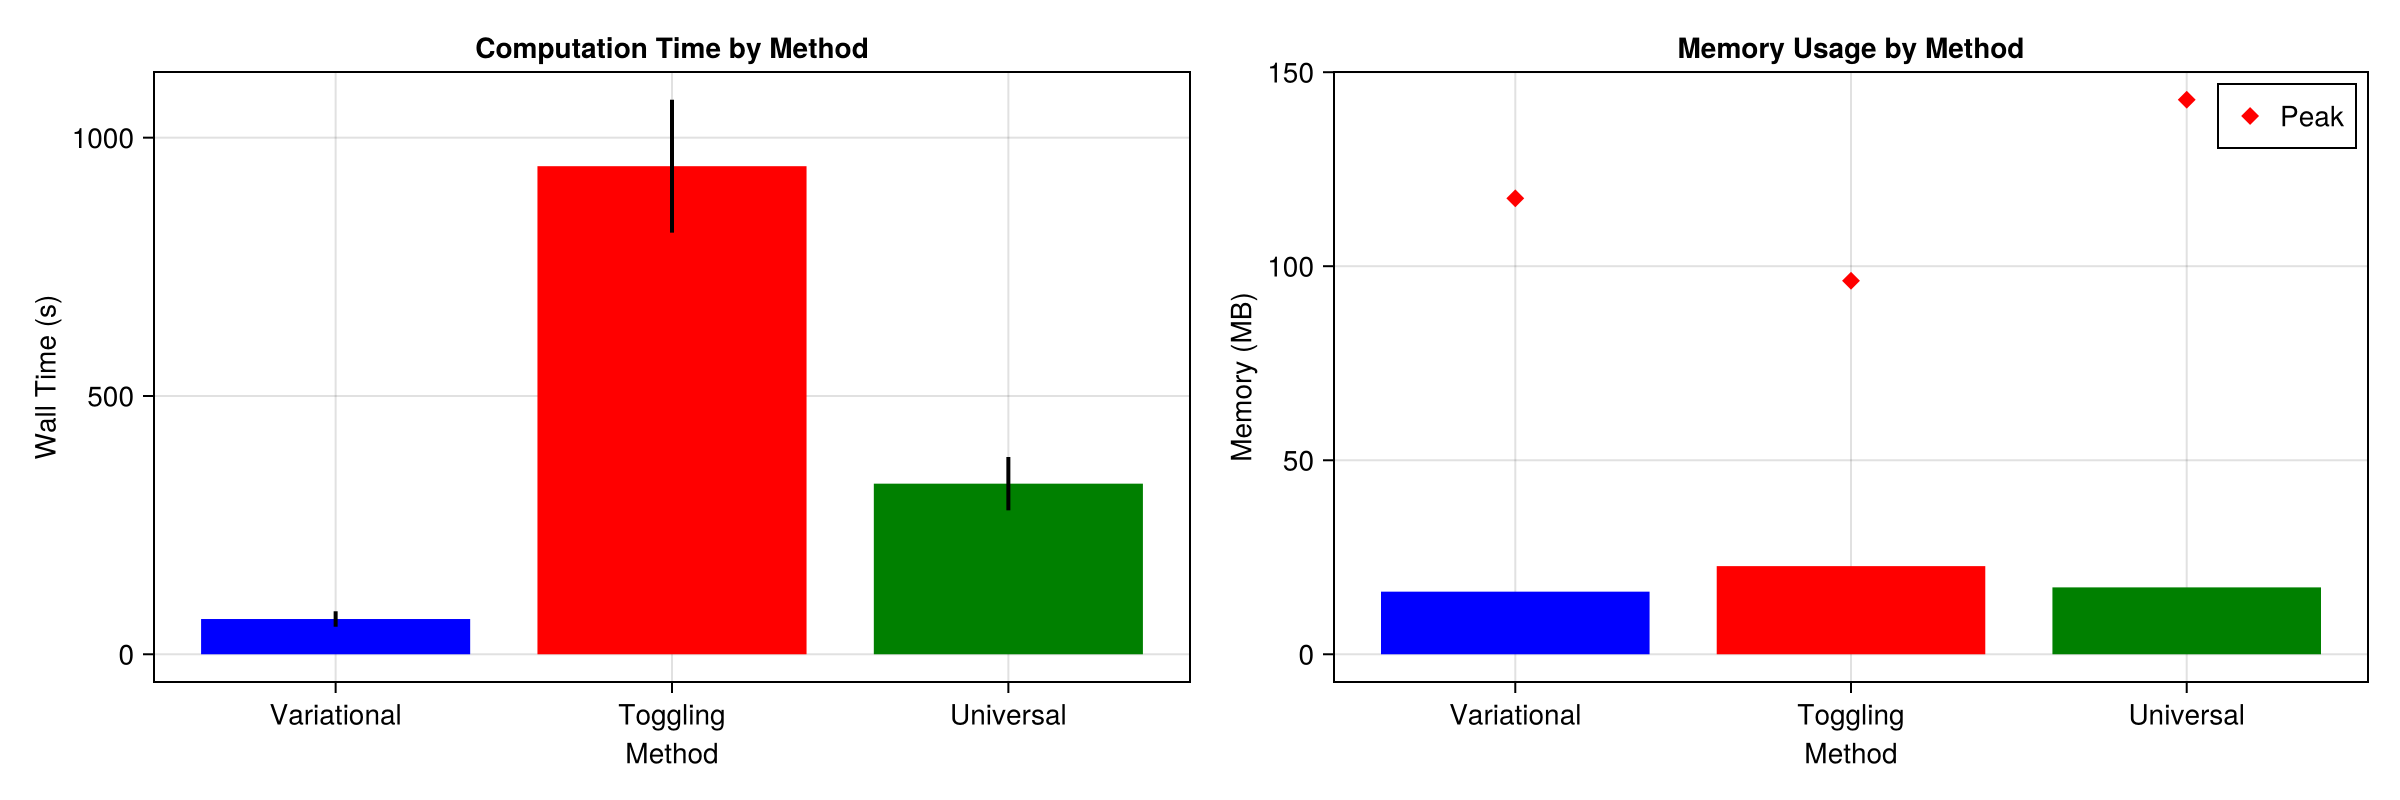

In [16]:
# Compute average resources per method
method_performance = Dict()
method_colors = [:blue, :red, :green]


for method in ["variational", "toggling", "universal"]
    times = Float64[]
    memories = Float64[]
    
    # Constraint-based
    for i in 1:n_seeds, j in 1:n_nines
        analysis = analyze_convergence(constraint_metrics[method][i,j])
        push!(times, analysis["total_wall_time"])
        push!(memories, analysis["peak_memory_mb"])
    end
    
    method_performance[method] = Dict(
        "avg_time" => mean(times),
        "std_time" => std(times),
        "avg_memory" => mean(memories),
        "max_memory" => maximum(memories)
    )
end

# Create comparison plot
fig = Figure(resolution=(1200, 400))

# Time comparison
ax1 = Axis(fig[1,1], 
    xlabel="Method", ylabel="Wall Time (s)",
    title="Computation Time by Method",
    xticks=(1:3, ["Variational", "Toggling", "Universal"])
)

times_mean = [method_performance[m]["avg_time"] for m in ["variational", "toggling", "universal"]]
times_std = [method_performance[m]["std_time"] for m in ["variational", "toggling", "universal"]]

barplot!(ax1, 1:3, times_mean, color=method_colors)
errorbars!(ax1, 1:3, times_mean, times_std, color=:black, linewidth=2)

# Memory comparison
ax2 = Axis(fig[1,2], 
    xlabel="Method", ylabel="Memory (MB)",
    title="Memory Usage by Method",
    xticks=(1:3, ["Variational", "Toggling", "Universal"])
)

mem_mean = [abs(method_performance[m]["avg_memory"]) for m in ["variational", "toggling", "universal"]]
mem_max = [method_performance[m]["max_memory"] for m in ["variational", "toggling", "universal"]]

barplot!(ax2, 1:3, mem_mean, color=method_colors)
Makie.scatter!(ax2, 1:3, mem_max, color=:red, marker=:diamond, markersize=10, label="Peak")

axislegend(ax2, position=:rt)
display(fig)

# Print summary
println("\n=== Method Resource Comparison ===")
for method in ["variational", "toggling", "universal"]
    println("\n$method:")
    println("  Avg time: $(round(method_performance[method]["avg_time"], digits=2))s")
    println("  Avg memory: $(round(method_performance[method]["avg_memory"], digits=1))MB")
end

In [15]:
# Print summary
# println("\n=== Method Resource Comparison ===")
# for method in ["variational", "toggling", "universal"]
#     println("\n$method:")
    
# end

display("\n variational:")
display("  Avg time: $(round(method_performance["variational"]["avg_time"], digits=2))s")
display("  Avg memory: $(round(method_performance["variational"]["avg_memory"], digits=1))MB")

display("\n toggling:")
display("  Avg time: $(round(method_performance["toggling"]["avg_time"], digits=2))s")
display("  Avg memory: $(round(method_performance["toggling"]["avg_memory"], digits=1))MB")

display("\n universal:")
display("  Avg time: $(round(method_performance["universal"]["avg_time"], digits=2))s")
display("  Avg memory: $(round(method_performance["universal"]["avg_memory"], digits=1))MB")

"\n variational:"

"  Avg time: 68.25s"

"  Avg memory: -16.1MB"

"\n toggling:"

"  Avg time: 944.82s"

"  Avg memory: 22.7MB"

"\n universal:"

"  Avg time: 330.27s"

"  Avg memory: -17.2MB"

compare penalty and constraint

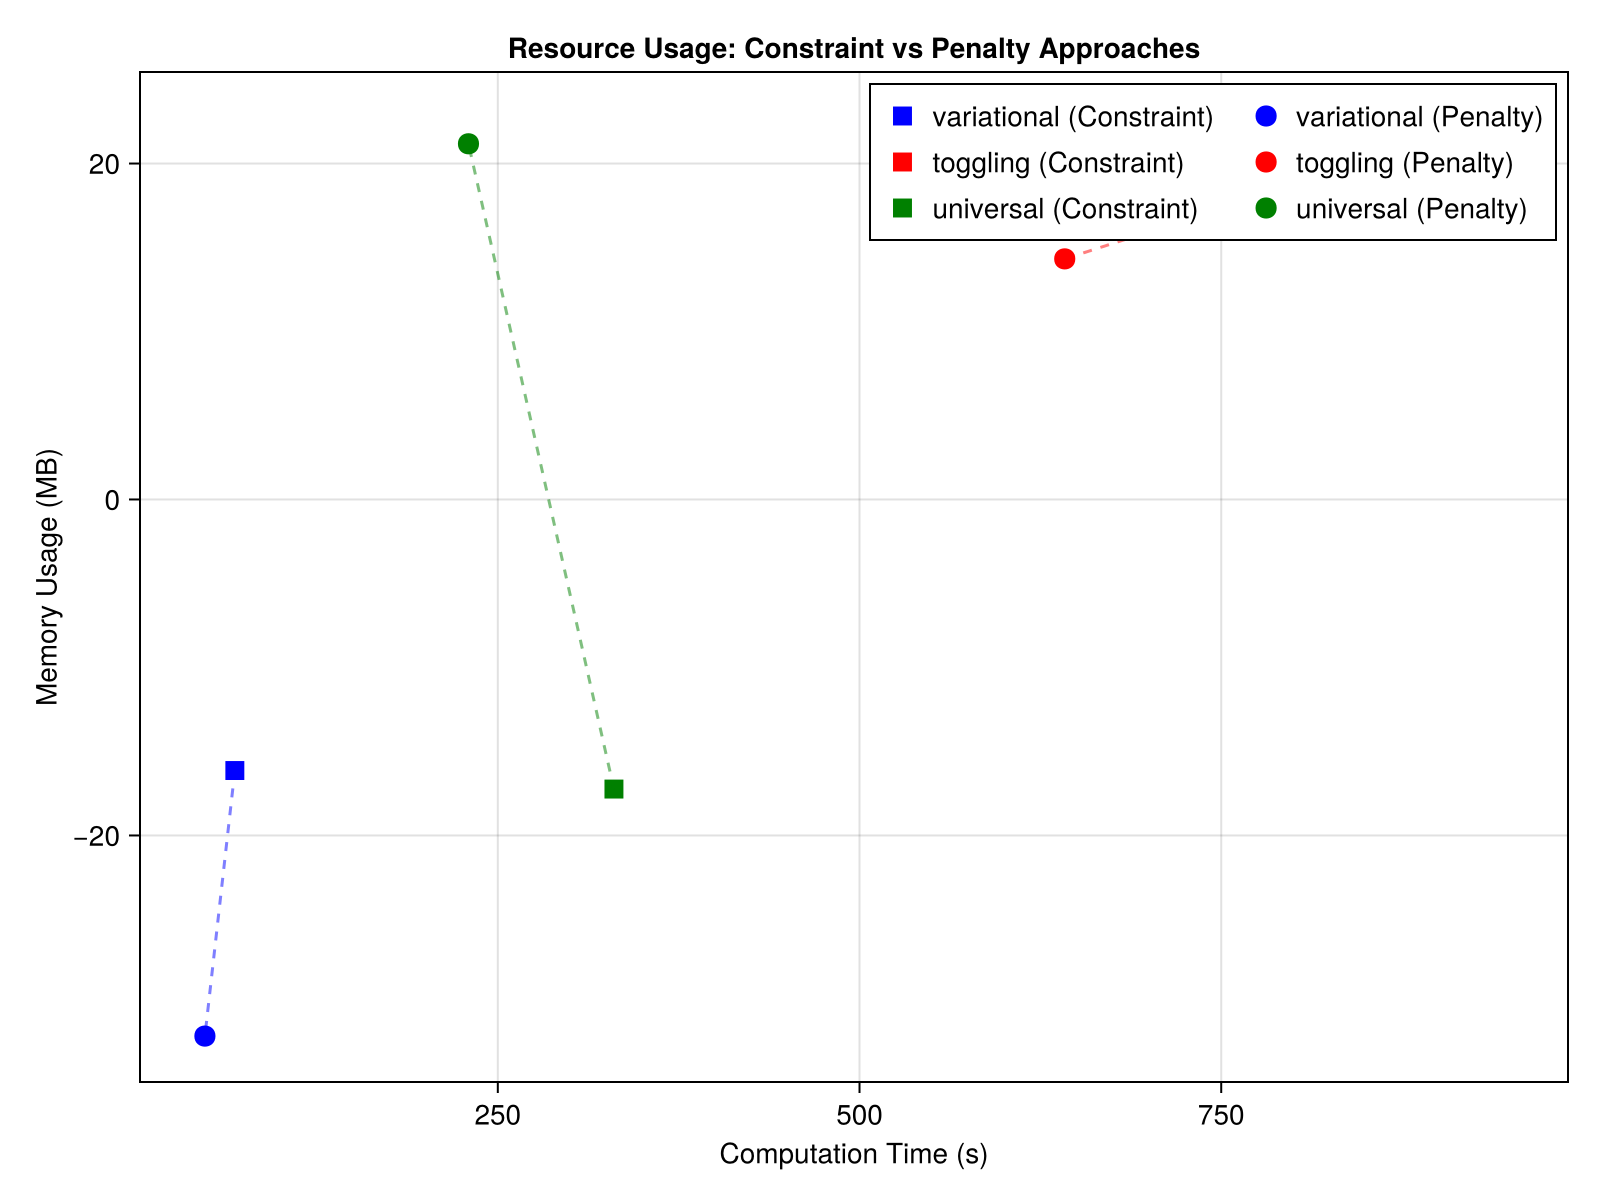

In [19]:
# Compare constraint vs penalty approaches
approach_performance = Dict()

for method in ["variational", "toggling", "universal"]
    # Constraint approach
    const_times = Float64[]
    const_mems = Float64[]
    for i in 1:n_seeds, j in 1:n_nines
        analysis = analyze_convergence(constraint_metrics[method][i,j])
        push!(const_times, analysis["total_wall_time"])
        push!(const_mems, analysis["peak_memory_mb"])
    end
    
    # Penalty approach
    pen_times = Float64[]
    pen_mems = Float64[]
    for i in 1:n_seeds, j in 1:n_lambdas
        analysis = analyze_convergence(penalty_metrics[method][i,j])
        push!(pen_times, analysis["total_wall_time"])
        push!(pen_mems, analysis["peak_memory_mb"])
    end
    
    approach_performance[method] = Dict(
        "constraint" => Dict("time" => mean(const_times), "memory" => mean(const_mems)),
        "penalty" => Dict("time" => mean(pen_times), "memory" => mean(pen_mems))
    )
end

# Create comparison visualization
fig = Figure(resolution=(800, 600))

ax = Axis(fig[1,1], 
    xlabel="Computation Time (s)", ylabel="Memory Usage (MB)",
    title="Resource Usage: Constraint vs Penalty Approaches"
)

for (idx, method) in enumerate(["variational", "toggling", "universal"])
    const_data = approach_performance[method]["constraint"]
    pen_data = approach_performance[method]["penalty"]
    
    # Plot constraint approach
    Makie.scatter!(ax, [const_data["time"]], [const_data["memory"]], 
        color=method_colors[idx], marker=:rect, markersize=15,
        label="$method (Constraint)")
    
    # Plot penalty approach
    Makie.scatter!(ax, [pen_data["time"]], [pen_data["memory"]], 
        color=method_colors[idx], marker=:circle, markersize=15,
        label="$method (Penalty)")
    
    # Connect with line
    lines!(ax, [const_data["time"], pen_data["time"]], 
        [const_data["memory"], pen_data["memory"]], 
        color=method_colors[idx], linestyle=:dash, alpha=0.5)
end

axislegend(ax, position=:rt, nbanks=2)
display(fig)

# Print comparison table
println("\n=== Constraint vs Penalty Resource Comparison ===")
println("Method        | Approach   | Time (s) | Memory (MB)")
println("-------------|------------|----------|------------")
for method in ["variational", "toggling", "universal"]
    const_data = approach_performance[method]["constraint"]
    pen_data = approach_performance[method]["penalty"]
    println("$(rpad(method, 12)) | Constraint | $(lpad(round(const_data["time"], digits=2), 8)) | $(lpad(round(const_data["memory"], digits=1), 10))")
    println("             | Penalty    | $(lpad(round(pen_data["time"], digits=2), 8)) | $(lpad(round(pen_data["memory"], digits=1), 10))")
end

# Efficiency ratio
println("\n=== Efficiency Ratios (Penalty/Constraint) ===")
for method in ["variational", "toggling", "universal"]
    time_ratio = approach_performance[method]["penalty"]["time"] / approach_performance[method]["constraint"]["time"]
    mem_ratio = approach_performance[method]["penalty"]["memory"] / approach_performance[method]["constraint"]["memory"]
    println("$method: Time ratio = $(round(time_ratio, digits=2)), Memory ratio = $(round(mem_ratio, digits=2))")
end

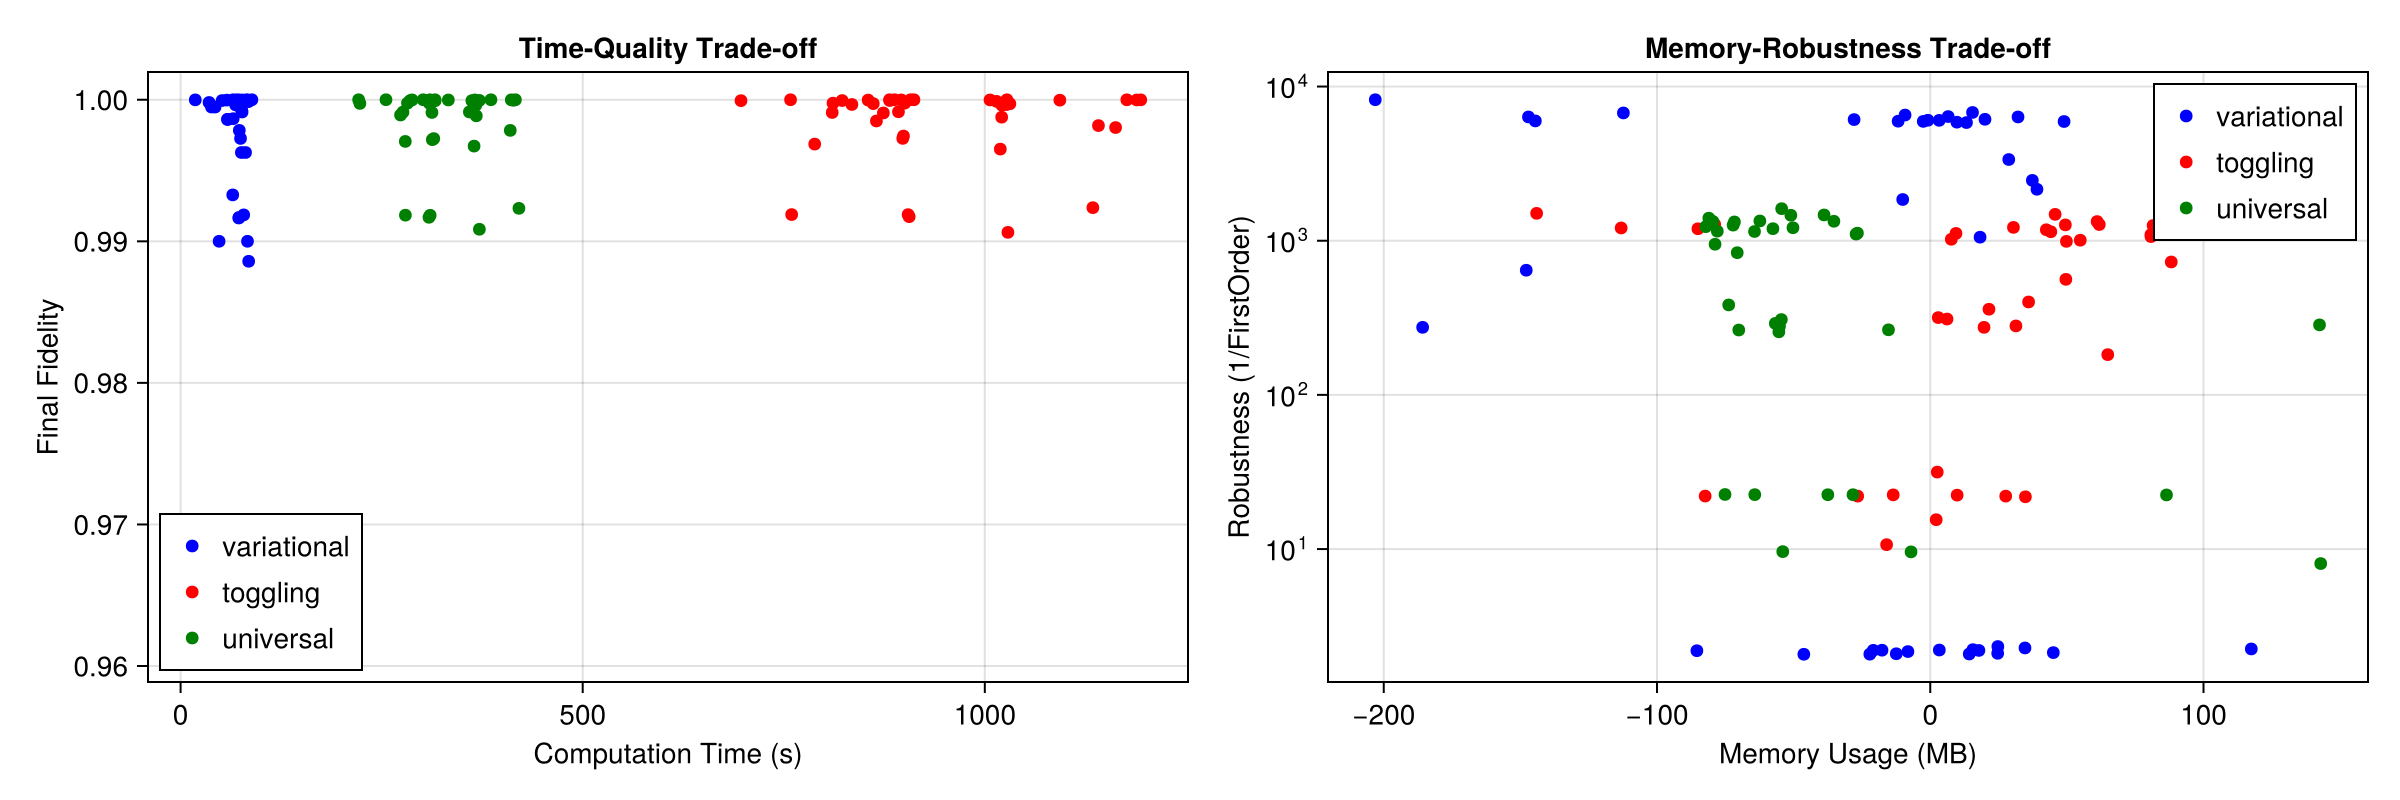

CairoMakie.Screen{IMAGE}


In [22]:
# Analyze resource usage vs solution quality
fig = Figure(resolution=(1200, 400))

# Time vs Fidelity trade-off
ax1 = Axis(fig[1,1], 
    xlabel="Computation Time (s)", ylabel="Final Fidelity",
    title="Time-Quality Trade-off"
)

# Memory vs Robustness trade-off  
ax2 = Axis(fig[1,2],
    xlabel="Memory Usage (MB)", ylabel="Robustness (1/FirstOrder)",
    title="Memory-Robustness Trade-off", 
    yscale=log10  # Use function instead of symbol
)

for (idx, method) in enumerate(["variational", "toggling", "universal"])
    times = Float64[]
    fidelities = Float64[]
    memories = Float64[]
    robustnesses = Float64[]
    
    # Collect data from constraint problems
    for i in 1:n_seeds, j in 1:n_nines
        analysis = analyze_convergence(constraint_metrics[method][i,j])
        prob = idx == 1 ? final_var_probs[i,j] : (idx == 2 ? final_tog_probs[i,j] : final_uni_probs[i,j])
        
        push!(times, analysis["total_wall_time"])
        push!(memories, analysis["peak_memory_mb"])
        push!(fidelities, unitary_rollout_fidelity(prob.trajectory, sys))
        
        obj = FirstOrderObjective(H₀_add, prob.trajectory)
        Z_vec = vec(prob.trajectory)
        push!(robustnesses, 1/obj.L(Z_vec))
    end
    
    Makie.scatter!(ax1, times, fidelities, color=method_colors[idx], label=method)
    Makie.scatter!(ax2, memories, robustnesses, color=method_colors[idx], label=method)
end

axislegend(ax1, position=:lb)
axislegend(ax2, position=:rt)
display(fig)